In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('server_operations.csv')
data.head(10)

,Latency (ms),Throughput (mb/s),Anomaly
0,13.046815,14.741152,0
1,13.408520,13.763270,0
2,14.195915,15.853181,0
3,14.914701,16.174260,0
4,13.576700,14.042849,0
5,13.922403,13.406469,0
6,12.822132,14.223188,0
7,15.676366,15.891691,0
8,16.162875,16.202998,0
9,12.666451,14.899084,1


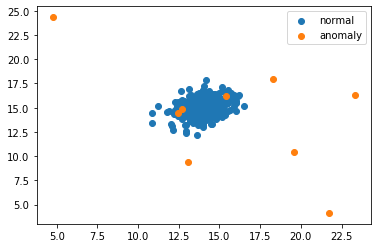

In [3]:
features = ['Latency (ms)', 'Throughput (mb/s)']
normal_data = data[data['Anomaly'] == 0][features].values
anomaly_data = data[data['Anomaly'] == 1][features].values

plt.scatter(normal_data[:, 0], normal_data[:, 1], label='normal')
plt.scatter(anomaly_data[:, 0], anomaly_data[:, 1], label='anomaly')
plt.legend()
plt.show()

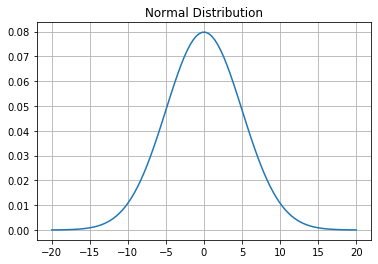

In [4]:
def normal_distribution(x, mean, variance):
    return 1 / (variance * np.sqrt(2 * np.pi * np.exp(np.square((x - mean) / variance))))

mean = 0
variance = 5
x = np.linspace(-20, 20, 100)
y = normal_distribution(x, mean, variance)
plt.title('Normal Distribution')
plt.plot(x, y)
plt.grid()
plt.show()

In [5]:
def is_anomaly(x, mean, variance, threshold):
    return np.prod(normal_distribution(x, mean, variance), axis=1) < threshold

In [6]:
# find the best threshold from this range
thresholds = np.linspace(0, 1, 10000, dtype='float')
best_th = None
best_f1 = -1

th_hist = []
f1_hist = []
recall_hist = []
precision_hist = []

# calculate features mean and variance for normal data
feature_means = np.sum(normal_data, axis=0) / normal_data.shape[0]
feature_variances = np.sqrt(np.sum(np.square(normal_data - feature_means), axis=0) / normal_data.shape[0])

# try every threshold
feature_data = data[features].values
labels = data['Anomaly'].values
for th in thresholds:
    pred = is_anomaly(feature_data, feature_means, feature_variances, th)
    
    true_pos = np.sum((pred == 1) & (labels == 1))
    false_pos = np.sum((pred == 1) & (labels == 0))
    false_neg = np.sum((pred == 0) & (labels == 1))
    if (true_pos + false_neg) == 0 or (true_pos + false_pos) == 0:
        # avoid div by zero
        continue
        
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = 2 * (recall * precision) / (recall + precision)
    
    # find the best f1 score
    if f1_score > best_f1:
        best_f1 = f1_score
        best_th = th
    f1_hist.append(f1_score)
    recall_hist.append(recall)
    precision_hist.append(precision)
    th_hist.append(th)

Best F1 Score=0.80000
Best Threshold=0.00010


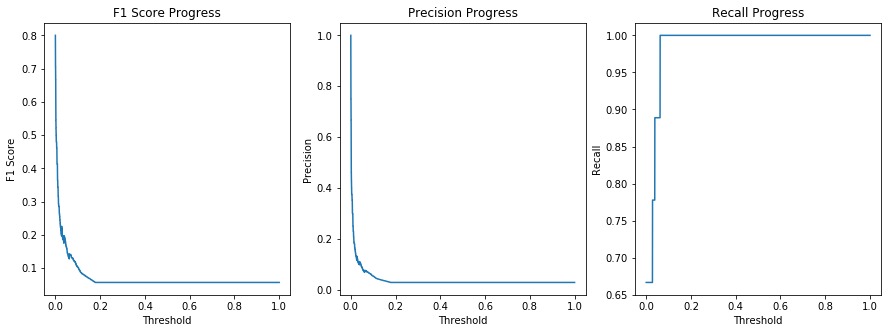

In [7]:
# Make the plot a little bit bigger than default one.
plt.figure(figsize=(15, 5))
    
plt.subplot(131)
plt.title('F1 Score Progress')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(th_hist, f1_hist)

plt.subplot(132)
plt.title('Precision Progress')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.plot(th_hist, precision_hist)

plt.subplot(133)
plt.title('Recall Progress')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.plot(th_hist, recall_hist)

print(f'Best F1 Score={best_f1:.5f}')
print(f'Best Threshold={best_th:.5f}')

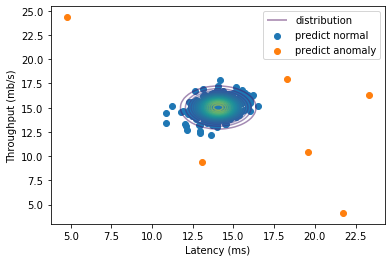

In [8]:
data_features = data[features].values

num_samples = 100
x = np.linspace(data_features[:, 0].min(), data_features[:, 0].max(), num_samples)
y = np.linspace(data_features[:, 1].min(), data_features[:, 1].max(), num_samples)
x, y = np.meshgrid(x, y)
d = np.c_[x.flatten(), y.flatten()]
z = np.prod(normal_distribution(d, feature_means, feature_variances), axis=1).reshape(x.shape)

pred = is_anomaly(feature_data, feature_means, feature_variances, best_th)
pred_normal = feature_data[pred == 0]
pred_anomaly = feature_data[pred == 1]

p1 = plt.scatter(pred_normal[:, 0], pred_normal[:, 1])
p2 = plt.scatter(pred_anomaly[:, 0], pred_anomaly[:, 1])
c = plt.contour(x, y, z, levels=20, alpha=0.5)
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend([c.collections[0], p1, p2], ['distribution', 'predict normal', 'predict anomaly'])
plt.show()